In [1]:
import os
import sys
sys.path.append('/homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman')
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy.integrate import odeint
from model_aug_koopman import Aug_Koopman_Model, Multi_INT_net, Aug_Koopman_ModelQP, get_initial_condition
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import datetime as dt
import csv
import pickle
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random
from sklearn.random_projection import sparse_random_matrix

In [2]:
file_name_results = 'Air_Passenger_PAug_Koopman'
output_file_folder = '/homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman/Identification/Models_And_Outputs/' + file_name_results +'/'
try:
    os.makedirs(output_file_folder)
    print("Directory " , output_file_folder ,  " Created ")
except FileExistsError:
    print("Directory " , output_file_folder ,  " already exists, overwriting results")  

Directory  /homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman/Identification/Models_And_Outputs/Air_Passenger_PAug_Koopman/  already exists, overwriting results


Text(0, 0.5, 'y')

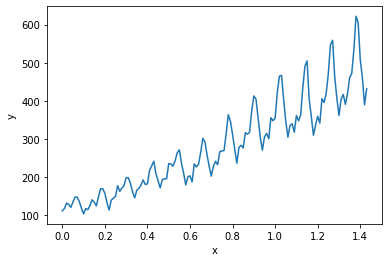

In [3]:
np.random.seed(42)
dim = 1
true_y = np.genfromtxt('/sanssauvegarde/homes/s17ouala/Complement/Koopman reduction/QP/QP_simple_signal/air_passenger.csv', delimiter=',')[1:,1]


csvfile = open('/sanssauvegarde/homes/s17ouala/Complement/Koopman reduction/QP/QP_simple_signal/air_passenger.csv', 'r')
reader = csv.reader(csvfile, delimiter='\t')
my_list = list(reader)
dates = []
dates_to_plot = []
for i in range(144):
    dates.append(my_list[1+i][0][:7].replace("-", "/"))
    dates_to_plot.append('')
formated_dates = [dt.datetime.strptime(d,'%Y/%m').date() for d in dates]
true_t = np.linspace(0, (true_y.shape[0]-1)/100, true_y.shape[0])
plt.plot(true_t,true_y)
plt.xlabel("x")
plt.ylabel("y")

In [4]:
dt   = true_t[1]-true_t[0]
S_train = true_y[:100].reshape(1,-1,1)
S_test  = true_y[100:].reshape(1,-1,1)
T_train = true_t[:100].reshape(1,-1,1)
T_test  = true_t[100:].reshape(1,-1,1)
Batch_size = S_train.shape[1]
X_train = S_train[0,:,:]
X_test  = S_test[:,:,:]
nb_Batch   = int(X_train.shape[0]/Batch_size)
X_train = torch.from_numpy(X_train.reshape(nb_Batch,Batch_size,dim)).double()
T_train = torch.from_numpy(T_train.reshape(nb_Batch,Batch_size,dim)).double()
batch_size_test = X_test.shape[1]
nb_batch_test   = int(X_test.shape[1]/batch_size_test)
X_test  = torch.from_numpy(X_test[:,:,:].reshape(nb_batch_test,batch_size_test,-1)).double()
T_test  = torch.from_numpy(T_test[:,:,:].reshape(nb_batch_test,batch_size_test,-1)).double()

In [5]:
dim_aug = 10
dim = 1
params = {}
params['description']='simple_QP_model_'+str(dim_aug+dim)
params['dim_input']=dim
params['dim_output']=dim_aug
params['dt_integration'] = dt
params['nb_Batch'] = nb_Batch
params['ntrain']=[7350,1]
params['dim_latent'] = dim_aug-dim
params['Imag_Eigen'] = False
params['Batch_size'] = Batch_size
params['transition_layers2'] = 0
params['transition_layers']  = 0
params['bi_linear_layers']   = 0
params['dim_hidden_linear']  = 0

In [6]:
params_learn = {}
params_learn['train_dir']    = '/home/saidouala/Documents/KoopmanReduction/Output_models/'
params_learn['train_repo']   = params['description']
params_learn['lr']           = .1
params_learn['len_seq_pred'] = 300
params_learn['Pretrained']   = False

In [7]:
model = Aug_Koopman_Model(params)
model_Multi_RINN = Multi_INT_net(params,model)
criterion = torch.nn.MSELoss(reduction='elementwise_mean')
optimizer = torch.optim.Adam(model.parameters(),lr = params_learn['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor = 0.9, patience=20, verbose=True, min_lr = 0.001)

In [8]:
# Learning loop
if params_learn['Pretrained']:
    model.load_state_dict(torch.load(output_file_folder + file_name_results + '.pt'))
else:
    aug_inp_count = []
    for t in range(params['ntrain'][0]):
            running_loss = 0.0
            for b in range(nb_Batch):
                    inp_conc = torch.cat((X_train[b,:,:],model.y_aug[b,:,:]),dim = -1)
                    pred, grad, phi = model(inp_conc,params['dt_integration'],0.0)[:3]
                    preds, error1, error_aug = [pred], [criterion(pred[:-1,:], inp_conc[1:,:])], [criterion(pred[:-1,dim:], inp_conc[1:,dim:])]
                    loss = torch.stack(error1).sum() #+ 1000*torch.stack(error_aug).mean()
                    running_loss += loss.item()
                    print(t,b,loss)
                    optimizer.zero_grad()
                    # Zero gradients, perform a backward pass, and update the weights.
                    loss.backward(retain_graph=True)
                    optimizer.step()
            scheduler.step(running_loss)
    torch.save(model.state_dict(), output_file_folder + file_name_results + '.pt')

0 0 tensor(56478.0116, dtype=torch.float64, grad_fn=<SumBackward0>)
1 0 tensor(56013.0490, dtype=torch.float64, grad_fn=<SumBackward0>)
2 0 tensor(55662.4704, dtype=torch.float64, grad_fn=<SumBackward0>)
3 0 tensor(55406.4350, dtype=torch.float64, grad_fn=<SumBackward0>)
4 0 tensor(55223.7421, dtype=torch.float64, grad_fn=<SumBackward0>)
5 0 tensor(55098.8529, dtype=torch.float64, grad_fn=<SumBackward0>)
6 0 tensor(55017.5726, dtype=torch.float64, grad_fn=<SumBackward0>)
7 0 tensor(54967.4926, dtype=torch.float64, grad_fn=<SumBackward0>)
8 0 tensor(54939.2606, dtype=torch.float64, grad_fn=<SumBackward0>)
9 0 tensor(54925.7897, dtype=torch.float64, grad_fn=<SumBackward0>)
10 0 tensor(54920.9881, dtype=torch.float64, grad_fn=<SumBackward0>)
11 0 tensor(54919.4433, dtype=torch.float64, grad_fn=<SumBackward0>)
12 0 tensor(54916.4422, dtype=torch.float64, grad_fn=<SumBackward0>)
13 0 tensor(54908.1082, dtype=torch.float64, grad_fn=<SumBackward0>)
14 0 tensor(54891.7961, dtype=torch.float64,

132 0 tensor(27919.7980, dtype=torch.float64, grad_fn=<SumBackward0>)
133 0 tensor(27690.4280, dtype=torch.float64, grad_fn=<SumBackward0>)
134 0 tensor(27462.6668, dtype=torch.float64, grad_fn=<SumBackward0>)
135 0 tensor(27236.3723, dtype=torch.float64, grad_fn=<SumBackward0>)
136 0 tensor(27011.4145, dtype=torch.float64, grad_fn=<SumBackward0>)
137 0 tensor(26787.6754, dtype=torch.float64, grad_fn=<SumBackward0>)
138 0 tensor(26565.0495, dtype=torch.float64, grad_fn=<SumBackward0>)
139 0 tensor(26343.4437, dtype=torch.float64, grad_fn=<SumBackward0>)
140 0 tensor(26122.7774, dtype=torch.float64, grad_fn=<SumBackward0>)
141 0 tensor(25902.9823, dtype=torch.float64, grad_fn=<SumBackward0>)
142 0 tensor(25684.0021, dtype=torch.float64, grad_fn=<SumBackward0>)
143 0 tensor(25465.7928, dtype=torch.float64, grad_fn=<SumBackward0>)
144 0 tensor(25248.3218, dtype=torch.float64, grad_fn=<SumBackward0>)
145 0 tensor(25031.5677, dtype=torch.float64, grad_fn=<SumBackward0>)
146 0 tensor(24815.5

256 0 tensor(11632.8317, dtype=torch.float64, grad_fn=<SumBackward0>)
257 0 tensor(11570.5905, dtype=torch.float64, grad_fn=<SumBackward0>)
258 0 tensor(11508.4966, dtype=torch.float64, grad_fn=<SumBackward0>)
259 0 tensor(11446.5430, dtype=torch.float64, grad_fn=<SumBackward0>)
260 0 tensor(11384.7226, dtype=torch.float64, grad_fn=<SumBackward0>)
261 0 tensor(11323.0293, dtype=torch.float64, grad_fn=<SumBackward0>)
262 0 tensor(11261.4568, dtype=torch.float64, grad_fn=<SumBackward0>)
263 0 tensor(11199.9995, dtype=torch.float64, grad_fn=<SumBackward0>)
264 0 tensor(11138.6518, dtype=torch.float64, grad_fn=<SumBackward0>)
265 0 tensor(11077.4088, dtype=torch.float64, grad_fn=<SumBackward0>)
266 0 tensor(11016.2655, dtype=torch.float64, grad_fn=<SumBackward0>)
267 0 tensor(10955.2174, dtype=torch.float64, grad_fn=<SumBackward0>)
268 0 tensor(10894.2604, dtype=torch.float64, grad_fn=<SumBackward0>)
269 0 tensor(10833.3904, dtype=torch.float64, grad_fn=<SumBackward0>)
270 0 tensor(10772.6

391 0 tensor(4188.2789, dtype=torch.float64, grad_fn=<SumBackward0>)
392 0 tensor(4150.6503, dtype=torch.float64, grad_fn=<SumBackward0>)
393 0 tensor(4113.5169, dtype=torch.float64, grad_fn=<SumBackward0>)
394 0 tensor(4076.8785, dtype=torch.float64, grad_fn=<SumBackward0>)
395 0 tensor(4040.7344, dtype=torch.float64, grad_fn=<SumBackward0>)
396 0 tensor(4005.0837, dtype=torch.float64, grad_fn=<SumBackward0>)
397 0 tensor(3969.9251, dtype=torch.float64, grad_fn=<SumBackward0>)
398 0 tensor(3935.2569, dtype=torch.float64, grad_fn=<SumBackward0>)
399 0 tensor(3901.0771, dtype=torch.float64, grad_fn=<SumBackward0>)
400 0 tensor(3867.3840, dtype=torch.float64, grad_fn=<SumBackward0>)
401 0 tensor(3834.1774, dtype=torch.float64, grad_fn=<SumBackward0>)
402 0 tensor(3801.4626, dtype=torch.float64, grad_fn=<SumBackward0>)
403 0 tensor(3769.2214, dtype=torch.float64, grad_fn=<SumBackward0>)
404 0 tensor(3737.4311, dtype=torch.float64, grad_fn=<SumBackward0>)
405 0 tensor(3706.1279, dtype=torc

520 0 tensor(1903.1321, dtype=torch.float64, grad_fn=<SumBackward0>)
521 0 tensor(1895.0191, dtype=torch.float64, grad_fn=<SumBackward0>)
522 0 tensor(1886.9602, dtype=torch.float64, grad_fn=<SumBackward0>)
523 0 tensor(1878.9560, dtype=torch.float64, grad_fn=<SumBackward0>)
524 0 tensor(1871.0071, dtype=torch.float64, grad_fn=<SumBackward0>)
525 0 tensor(1863.1140, dtype=torch.float64, grad_fn=<SumBackward0>)
526 0 tensor(1855.2767, dtype=torch.float64, grad_fn=<SumBackward0>)
527 0 tensor(1847.4948, dtype=torch.float64, grad_fn=<SumBackward0>)
528 0 tensor(1839.7676, dtype=torch.float64, grad_fn=<SumBackward0>)
529 0 tensor(1832.0942, dtype=torch.float64, grad_fn=<SumBackward0>)
530 0 tensor(1824.4737, dtype=torch.float64, grad_fn=<SumBackward0>)
531 0 tensor(1816.9052, dtype=torch.float64, grad_fn=<SumBackward0>)
532 0 tensor(1809.3878, dtype=torch.float64, grad_fn=<SumBackward0>)
533 0 tensor(1801.9207, dtype=torch.float64, grad_fn=<SumBackward0>)
534 0 tensor(1794.5033, dtype=torc

641 0 tensor(1193.5909, dtype=torch.float64, grad_fn=<SumBackward0>)
642 0 tensor(1189.2066, dtype=torch.float64, grad_fn=<SumBackward0>)
643 0 tensor(1184.8869, dtype=torch.float64, grad_fn=<SumBackward0>)
644 0 tensor(1180.5846, dtype=torch.float64, grad_fn=<SumBackward0>)
645 0 tensor(1176.2618, dtype=torch.float64, grad_fn=<SumBackward0>)
646 0 tensor(1171.9118, dtype=torch.float64, grad_fn=<SumBackward0>)
647 0 tensor(1167.5584, dtype=torch.float64, grad_fn=<SumBackward0>)
648 0 tensor(1163.2327, dtype=torch.float64, grad_fn=<SumBackward0>)
649 0 tensor(1158.9525, dtype=torch.float64, grad_fn=<SumBackward0>)
650 0 tensor(1154.7133, dtype=torch.float64, grad_fn=<SumBackward0>)
651 0 tensor(1150.4969, dtype=torch.float64, grad_fn=<SumBackward0>)
652 0 tensor(1146.2851, dtype=torch.float64, grad_fn=<SumBackward0>)
653 0 tensor(1142.0696, dtype=torch.float64, grad_fn=<SumBackward0>)
654 0 tensor(1137.8545, dtype=torch.float64, grad_fn=<SumBackward0>)
655 0 tensor(1133.6506, dtype=torc

776 0 tensor(732.9309, dtype=torch.float64, grad_fn=<SumBackward0>)
777 0 tensor(729.9860, dtype=torch.float64, grad_fn=<SumBackward0>)
778 0 tensor(727.0938, dtype=torch.float64, grad_fn=<SumBackward0>)
779 0 tensor(724.4435, dtype=torch.float64, grad_fn=<SumBackward0>)
780 0 tensor(722.0728, dtype=torch.float64, grad_fn=<SumBackward0>)
781 0 tensor(719.8662, dtype=torch.float64, grad_fn=<SumBackward0>)
782 0 tensor(717.6476, dtype=torch.float64, grad_fn=<SumBackward0>)
783 0 tensor(715.2851, dtype=torch.float64, grad_fn=<SumBackward0>)
784 0 tensor(712.7530, dtype=torch.float64, grad_fn=<SumBackward0>)
785 0 tensor(710.1464, dtype=torch.float64, grad_fn=<SumBackward0>)
786 0 tensor(707.6035, dtype=torch.float64, grad_fn=<SumBackward0>)
787 0 tensor(705.2092, dtype=torch.float64, grad_fn=<SumBackward0>)
788 0 tensor(702.9468, dtype=torch.float64, grad_fn=<SumBackward0>)
789 0 tensor(700.7300, dtype=torch.float64, grad_fn=<SumBackward0>)
790 0 tensor(698.4706, dtype=torch.float64, grad

906 0 tensor(499.0804, dtype=torch.float64, grad_fn=<SumBackward0>)
907 0 tensor(497.8482, dtype=torch.float64, grad_fn=<SumBackward0>)
908 0 tensor(496.6265, dtype=torch.float64, grad_fn=<SumBackward0>)
909 0 tensor(495.4143, dtype=torch.float64, grad_fn=<SumBackward0>)
910 0 tensor(494.2096, dtype=torch.float64, grad_fn=<SumBackward0>)
911 0 tensor(493.0102, dtype=torch.float64, grad_fn=<SumBackward0>)
912 0 tensor(491.8150, dtype=torch.float64, grad_fn=<SumBackward0>)
913 0 tensor(490.6237, dtype=torch.float64, grad_fn=<SumBackward0>)
914 0 tensor(489.4371, dtype=torch.float64, grad_fn=<SumBackward0>)
915 0 tensor(488.2560, dtype=torch.float64, grad_fn=<SumBackward0>)
916 0 tensor(487.0814, dtype=torch.float64, grad_fn=<SumBackward0>)
917 0 tensor(485.9138, dtype=torch.float64, grad_fn=<SumBackward0>)
918 0 tensor(484.7533, dtype=torch.float64, grad_fn=<SumBackward0>)
919 0 tensor(483.5998, dtype=torch.float64, grad_fn=<SumBackward0>)
920 0 tensor(482.4528, dtype=torch.float64, grad

1032 0 tensor(382.9155, dtype=torch.float64, grad_fn=<SumBackward0>)
1033 0 tensor(382.2222, dtype=torch.float64, grad_fn=<SumBackward0>)
1034 0 tensor(381.5319, dtype=torch.float64, grad_fn=<SumBackward0>)
1035 0 tensor(380.8454, dtype=torch.float64, grad_fn=<SumBackward0>)
1036 0 tensor(380.1624, dtype=torch.float64, grad_fn=<SumBackward0>)
1037 0 tensor(379.4823, dtype=torch.float64, grad_fn=<SumBackward0>)
1038 0 tensor(378.8043, dtype=torch.float64, grad_fn=<SumBackward0>)
1039 0 tensor(378.1283, dtype=torch.float64, grad_fn=<SumBackward0>)
1040 0 tensor(377.4541, dtype=torch.float64, grad_fn=<SumBackward0>)
1041 0 tensor(376.7822, dtype=torch.float64, grad_fn=<SumBackward0>)
1042 0 tensor(376.1130, dtype=torch.float64, grad_fn=<SumBackward0>)
1043 0 tensor(375.4466, dtype=torch.float64, grad_fn=<SumBackward0>)
1044 0 tensor(374.7831, dtype=torch.float64, grad_fn=<SumBackward0>)
1045 0 tensor(374.1223, dtype=torch.float64, grad_fn=<SumBackward0>)
1046 0 tensor(373.4638, dtype=torc

1159 0 tensor(311.4500, dtype=torch.float64, grad_fn=<SumBackward0>)
1160 0 tensor(310.9802, dtype=torch.float64, grad_fn=<SumBackward0>)
1161 0 tensor(310.5130, dtype=torch.float64, grad_fn=<SumBackward0>)
1162 0 tensor(310.0531, dtype=torch.float64, grad_fn=<SumBackward0>)
1163 0 tensor(309.5995, dtype=torch.float64, grad_fn=<SumBackward0>)
1164 0 tensor(309.1478, dtype=torch.float64, grad_fn=<SumBackward0>)
1165 0 tensor(308.6941, dtype=torch.float64, grad_fn=<SumBackward0>)
1166 0 tensor(308.2375, dtype=torch.float64, grad_fn=<SumBackward0>)
1167 0 tensor(307.7802, dtype=torch.float64, grad_fn=<SumBackward0>)
1168 0 tensor(307.3254, dtype=torch.float64, grad_fn=<SumBackward0>)
1169 0 tensor(306.8745, dtype=torch.float64, grad_fn=<SumBackward0>)
1170 0 tensor(306.4270, dtype=torch.float64, grad_fn=<SumBackward0>)
1171 0 tensor(305.9811, dtype=torch.float64, grad_fn=<SumBackward0>)
1172 0 tensor(305.5351, dtype=torch.float64, grad_fn=<SumBackward0>)
1173 0 tensor(305.0883, dtype=torc

1285 0 tensor(261.3704, dtype=torch.float64, grad_fn=<SumBackward0>)
1286 0 tensor(261.0473, dtype=torch.float64, grad_fn=<SumBackward0>)
1287 0 tensor(260.7463, dtype=torch.float64, grad_fn=<SumBackward0>)
1288 0 tensor(260.4216, dtype=torch.float64, grad_fn=<SumBackward0>)
1289 0 tensor(260.0593, dtype=torch.float64, grad_fn=<SumBackward0>)
1290 0 tensor(259.6838, dtype=torch.float64, grad_fn=<SumBackward0>)
1291 0 tensor(259.3274, dtype=torch.float64, grad_fn=<SumBackward0>)
1292 0 tensor(258.9996, dtype=torch.float64, grad_fn=<SumBackward0>)
1293 0 tensor(258.6838, dtype=torch.float64, grad_fn=<SumBackward0>)
1294 0 tensor(258.3572, dtype=torch.float64, grad_fn=<SumBackward0>)
1295 0 tensor(258.0115, dtype=torch.float64, grad_fn=<SumBackward0>)
1296 0 tensor(257.6570, dtype=torch.float64, grad_fn=<SumBackward0>)
1297 0 tensor(257.3102, dtype=torch.float64, grad_fn=<SumBackward0>)
1298 0 tensor(256.9785, dtype=torch.float64, grad_fn=<SumBackward0>)
1299 0 tensor(256.6561, dtype=torc

1428 0 tensor(218.8200, dtype=torch.float64, grad_fn=<SumBackward0>)
1429 0 tensor(218.4786, dtype=torch.float64, grad_fn=<SumBackward0>)
1430 0 tensor(218.1797, dtype=torch.float64, grad_fn=<SumBackward0>)
1431 0 tensor(217.9493, dtype=torch.float64, grad_fn=<SumBackward0>)
1432 0 tensor(217.7414, dtype=torch.float64, grad_fn=<SumBackward0>)
1433 0 tensor(217.4976, dtype=torch.float64, grad_fn=<SumBackward0>)
1434 0 tensor(217.2073, dtype=torch.float64, grad_fn=<SumBackward0>)
1435 0 tensor(216.9075, dtype=torch.float64, grad_fn=<SumBackward0>)
1436 0 tensor(216.6373, dtype=torch.float64, grad_fn=<SumBackward0>)
1437 0 tensor(216.4003, dtype=torch.float64, grad_fn=<SumBackward0>)
1438 0 tensor(216.1703, dtype=torch.float64, grad_fn=<SumBackward0>)
1439 0 tensor(215.9208, dtype=torch.float64, grad_fn=<SumBackward0>)
1440 0 tensor(215.6486, dtype=torch.float64, grad_fn=<SumBackward0>)
1441 0 tensor(215.3716, dtype=torch.float64, grad_fn=<SumBackward0>)
1442 0 tensor(215.1092, dtype=torc

1549 0 tensor(190.6790, dtype=torch.float64, grad_fn=<SumBackward0>)
1550 0 tensor(190.3914, dtype=torch.float64, grad_fn=<SumBackward0>)
1551 0 tensor(191.6053, dtype=torch.float64, grad_fn=<SumBackward0>)
1552 0 tensor(192.6575, dtype=torch.float64, grad_fn=<SumBackward0>)
1553 0 tensor(192.2867, dtype=torch.float64, grad_fn=<SumBackward0>)
1554 0 tensor(190.6789, dtype=torch.float64, grad_fn=<SumBackward0>)
1555 0 tensor(189.2377, dtype=torch.float64, grad_fn=<SumBackward0>)
1556 0 tensor(189.0329, dtype=torch.float64, grad_fn=<SumBackward0>)
1557 0 tensor(189.7298, dtype=torch.float64, grad_fn=<SumBackward0>)
1558 0 tensor(190.1246, dtype=torch.float64, grad_fn=<SumBackward0>)
1559 0 tensor(189.5100, dtype=torch.float64, grad_fn=<SumBackward0>)
1560 0 tensor(188.3944, dtype=torch.float64, grad_fn=<SumBackward0>)
1561 0 tensor(187.7822, dtype=torch.float64, grad_fn=<SumBackward0>)
1562 0 tensor(187.9525, dtype=torch.float64, grad_fn=<SumBackward0>)
1563 0 tensor(188.2657, dtype=torc

1681 0 tensor(165.0227, dtype=torch.float64, grad_fn=<SumBackward0>)
1682 0 tensor(164.8491, dtype=torch.float64, grad_fn=<SumBackward0>)
1683 0 tensor(164.6758, dtype=torch.float64, grad_fn=<SumBackward0>)
1684 0 tensor(164.5027, dtype=torch.float64, grad_fn=<SumBackward0>)
1685 0 tensor(164.3299, dtype=torch.float64, grad_fn=<SumBackward0>)
1686 0 tensor(164.1575, dtype=torch.float64, grad_fn=<SumBackward0>)
1687 0 tensor(163.9854, dtype=torch.float64, grad_fn=<SumBackward0>)
1688 0 tensor(163.8138, dtype=torch.float64, grad_fn=<SumBackward0>)
1689 0 tensor(163.6428, dtype=torch.float64, grad_fn=<SumBackward0>)
1690 0 tensor(163.4726, dtype=torch.float64, grad_fn=<SumBackward0>)
1691 0 tensor(163.3036, dtype=torch.float64, grad_fn=<SumBackward0>)
1692 0 tensor(163.1364, dtype=torch.float64, grad_fn=<SumBackward0>)
1693 0 tensor(162.9721, dtype=torch.float64, grad_fn=<SumBackward0>)
1694 0 tensor(162.8127, dtype=torch.float64, grad_fn=<SumBackward0>)
1695 0 tensor(162.6616, dtype=torc

1816 0 tensor(143.7886, dtype=torch.float64, grad_fn=<SumBackward0>)
1817 0 tensor(143.6452, dtype=torch.float64, grad_fn=<SumBackward0>)
1818 0 tensor(143.5020, dtype=torch.float64, grad_fn=<SumBackward0>)
1819 0 tensor(143.3590, dtype=torch.float64, grad_fn=<SumBackward0>)
1820 0 tensor(143.2162, dtype=torch.float64, grad_fn=<SumBackward0>)
1821 0 tensor(143.0736, dtype=torch.float64, grad_fn=<SumBackward0>)
1822 0 tensor(142.9311, dtype=torch.float64, grad_fn=<SumBackward0>)
1823 0 tensor(142.7888, dtype=torch.float64, grad_fn=<SumBackward0>)
1824 0 tensor(142.6467, dtype=torch.float64, grad_fn=<SumBackward0>)
1825 0 tensor(142.5048, dtype=torch.float64, grad_fn=<SumBackward0>)
1826 0 tensor(142.3630, dtype=torch.float64, grad_fn=<SumBackward0>)
1827 0 tensor(142.2214, dtype=torch.float64, grad_fn=<SumBackward0>)
1828 0 tensor(142.0800, dtype=torch.float64, grad_fn=<SumBackward0>)
1829 0 tensor(141.9388, dtype=torch.float64, grad_fn=<SumBackward0>)
1830 0 tensor(141.7978, dtype=torc

1957 0 tensor(125.3897, dtype=torch.float64, grad_fn=<SumBackward0>)
1958 0 tensor(125.2699, dtype=torch.float64, grad_fn=<SumBackward0>)
1959 0 tensor(125.1496, dtype=torch.float64, grad_fn=<SumBackward0>)
1960 0 tensor(125.0300, dtype=torch.float64, grad_fn=<SumBackward0>)
1961 0 tensor(124.9120, dtype=torch.float64, grad_fn=<SumBackward0>)
1962 0 tensor(124.7948, dtype=torch.float64, grad_fn=<SumBackward0>)
1963 0 tensor(124.6773, dtype=torch.float64, grad_fn=<SumBackward0>)
1964 0 tensor(124.5590, dtype=torch.float64, grad_fn=<SumBackward0>)
1965 0 tensor(124.4403, dtype=torch.float64, grad_fn=<SumBackward0>)
1966 0 tensor(124.3219, dtype=torch.float64, grad_fn=<SumBackward0>)
1967 0 tensor(124.2042, dtype=torch.float64, grad_fn=<SumBackward0>)
1968 0 tensor(124.0870, dtype=torch.float64, grad_fn=<SumBackward0>)
1969 0 tensor(123.9699, dtype=torch.float64, grad_fn=<SumBackward0>)
1970 0 tensor(123.8529, dtype=torch.float64, grad_fn=<SumBackward0>)
1971 0 tensor(123.7359, dtype=torc

2078 0 tensor(113.3780, dtype=torch.float64, grad_fn=<SumBackward0>)
2079 0 tensor(113.8989, dtype=torch.float64, grad_fn=<SumBackward0>)
2080 0 tensor(114.4392, dtype=torch.float64, grad_fn=<SumBackward0>)
2081 0 tensor(114.1549, dtype=torch.float64, grad_fn=<SumBackward0>)
2082 0 tensor(113.3723, dtype=torch.float64, grad_fn=<SumBackward0>)
2083 0 tensor(112.5539, dtype=torch.float64, grad_fn=<SumBackward0>)
2084 0 tensor(112.2835, dtype=torch.float64, grad_fn=<SumBackward0>)
2085 0 tensor(112.7476, dtype=torch.float64, grad_fn=<SumBackward0>)
2086 0 tensor(112.9389, dtype=torch.float64, grad_fn=<SumBackward0>)
2087 0 tensor(112.0710, dtype=torch.float64, grad_fn=<SumBackward0>)
2088 0 tensor(111.1957, dtype=torch.float64, grad_fn=<SumBackward0>)
2089 0 tensor(111.5262, dtype=torch.float64, grad_fn=<SumBackward0>)
2090 0 tensor(112.1228, dtype=torch.float64, grad_fn=<SumBackward0>)
2091 0 tensor(111.5913, dtype=torch.float64, grad_fn=<SumBackward0>)
2092 0 tensor(110.6716, dtype=torc

2223 0 tensor(98.4032, dtype=torch.float64, grad_fn=<SumBackward0>)
2224 0 tensor(98.3164, dtype=torch.float64, grad_fn=<SumBackward0>)
2225 0 tensor(98.2297, dtype=torch.float64, grad_fn=<SumBackward0>)
2226 0 tensor(98.1430, dtype=torch.float64, grad_fn=<SumBackward0>)
2227 0 tensor(98.0565, dtype=torch.float64, grad_fn=<SumBackward0>)
2228 0 tensor(97.9700, dtype=torch.float64, grad_fn=<SumBackward0>)
2229 0 tensor(97.8837, dtype=torch.float64, grad_fn=<SumBackward0>)
2230 0 tensor(97.7974, dtype=torch.float64, grad_fn=<SumBackward0>)
2231 0 tensor(97.7112, dtype=torch.float64, grad_fn=<SumBackward0>)
2232 0 tensor(97.6251, dtype=torch.float64, grad_fn=<SumBackward0>)
2233 0 tensor(97.5390, dtype=torch.float64, grad_fn=<SumBackward0>)
2234 0 tensor(97.4531, dtype=torch.float64, grad_fn=<SumBackward0>)
2235 0 tensor(97.3673, dtype=torch.float64, grad_fn=<SumBackward0>)
2236 0 tensor(97.2815, dtype=torch.float64, grad_fn=<SumBackward0>)
2237 0 tensor(97.1958, dtype=torch.float64, grad

2358 0 tensor(87.5684, dtype=torch.float64, grad_fn=<SumBackward0>)
2359 0 tensor(87.4930, dtype=torch.float64, grad_fn=<SumBackward0>)
2360 0 tensor(87.4340, dtype=torch.float64, grad_fn=<SumBackward0>)
2361 0 tensor(87.3638, dtype=torch.float64, grad_fn=<SumBackward0>)
2362 0 tensor(87.2775, dtype=torch.float64, grad_fn=<SumBackward0>)
2363 0 tensor(87.1949, dtype=torch.float64, grad_fn=<SumBackward0>)
2364 0 tensor(87.1258, dtype=torch.float64, grad_fn=<SumBackward0>)
2365 0 tensor(87.0586, dtype=torch.float64, grad_fn=<SumBackward0>)
2366 0 tensor(86.9827, dtype=torch.float64, grad_fn=<SumBackward0>)
2367 0 tensor(86.9030, dtype=torch.float64, grad_fn=<SumBackward0>)
2368 0 tensor(86.8279, dtype=torch.float64, grad_fn=<SumBackward0>)
2369 0 tensor(86.7565, dtype=torch.float64, grad_fn=<SumBackward0>)
2370 0 tensor(86.6840, dtype=torch.float64, grad_fn=<SumBackward0>)
2371 0 tensor(86.6094, dtype=torch.float64, grad_fn=<SumBackward0>)
2372 0 tensor(86.5350, dtype=torch.float64, grad

2500 0 tensor(77.6614, dtype=torch.float64, grad_fn=<SumBackward0>)
2501 0 tensor(77.5959, dtype=torch.float64, grad_fn=<SumBackward0>)
2502 0 tensor(77.5305, dtype=torch.float64, grad_fn=<SumBackward0>)
2503 0 tensor(77.4651, dtype=torch.float64, grad_fn=<SumBackward0>)
2504 0 tensor(77.3998, dtype=torch.float64, grad_fn=<SumBackward0>)
2505 0 tensor(77.3346, dtype=torch.float64, grad_fn=<SumBackward0>)
2506 0 tensor(77.2694, dtype=torch.float64, grad_fn=<SumBackward0>)
2507 0 tensor(77.2042, dtype=torch.float64, grad_fn=<SumBackward0>)
2508 0 tensor(77.1391, dtype=torch.float64, grad_fn=<SumBackward0>)
2509 0 tensor(77.0741, dtype=torch.float64, grad_fn=<SumBackward0>)
2510 0 tensor(77.0091, dtype=torch.float64, grad_fn=<SumBackward0>)
2511 0 tensor(76.9441, dtype=torch.float64, grad_fn=<SumBackward0>)
2512 0 tensor(76.8793, dtype=torch.float64, grad_fn=<SumBackward0>)
2513 0 tensor(76.8144, dtype=torch.float64, grad_fn=<SumBackward0>)
2514 0 tensor(76.7497, dtype=torch.float64, grad

2639 0 tensor(69.6828, dtype=torch.float64, grad_fn=<SumBackward0>)
2640 0 tensor(69.6305, dtype=torch.float64, grad_fn=<SumBackward0>)
2641 0 tensor(69.5788, dtype=torch.float64, grad_fn=<SumBackward0>)
2642 0 tensor(69.5270, dtype=torch.float64, grad_fn=<SumBackward0>)
2643 0 tensor(69.4750, dtype=torch.float64, grad_fn=<SumBackward0>)
2644 0 tensor(69.4231, dtype=torch.float64, grad_fn=<SumBackward0>)
2645 0 tensor(69.3714, dtype=torch.float64, grad_fn=<SumBackward0>)
2646 0 tensor(69.3196, dtype=torch.float64, grad_fn=<SumBackward0>)
2647 0 tensor(69.2678, dtype=torch.float64, grad_fn=<SumBackward0>)
2648 0 tensor(69.2161, dtype=torch.float64, grad_fn=<SumBackward0>)
2649 0 tensor(69.1645, dtype=torch.float64, grad_fn=<SumBackward0>)
2650 0 tensor(69.1128, dtype=torch.float64, grad_fn=<SumBackward0>)
2651 0 tensor(69.0612, dtype=torch.float64, grad_fn=<SumBackward0>)
2652 0 tensor(69.0097, dtype=torch.float64, grad_fn=<SumBackward0>)
2653 0 tensor(68.9581, dtype=torch.float64, grad

2761 0 tensor(63.5670, dtype=torch.float64, grad_fn=<SumBackward0>)
2762 0 tensor(63.5186, dtype=torch.float64, grad_fn=<SumBackward0>)
2763 0 tensor(63.4703, dtype=torch.float64, grad_fn=<SumBackward0>)
2764 0 tensor(63.4220, dtype=torch.float64, grad_fn=<SumBackward0>)
2765 0 tensor(63.3737, dtype=torch.float64, grad_fn=<SumBackward0>)
2766 0 tensor(63.3254, dtype=torch.float64, grad_fn=<SumBackward0>)
2767 0 tensor(63.2771, dtype=torch.float64, grad_fn=<SumBackward0>)
2768 0 tensor(63.2289, dtype=torch.float64, grad_fn=<SumBackward0>)
2769 0 tensor(63.1807, dtype=torch.float64, grad_fn=<SumBackward0>)
2770 0 tensor(63.1326, dtype=torch.float64, grad_fn=<SumBackward0>)
2771 0 tensor(63.0844, dtype=torch.float64, grad_fn=<SumBackward0>)
2772 0 tensor(63.0363, dtype=torch.float64, grad_fn=<SumBackward0>)
2773 0 tensor(62.9882, dtype=torch.float64, grad_fn=<SumBackward0>)
2774 0 tensor(62.9402, dtype=torch.float64, grad_fn=<SumBackward0>)
2775 0 tensor(62.8922, dtype=torch.float64, grad

2896 0 tensor(57.2617, dtype=torch.float64, grad_fn=<SumBackward0>)
2897 0 tensor(57.2165, dtype=torch.float64, grad_fn=<SumBackward0>)
2898 0 tensor(57.1714, dtype=torch.float64, grad_fn=<SumBackward0>)
2899 0 tensor(57.1263, dtype=torch.float64, grad_fn=<SumBackward0>)
2900 0 tensor(57.0812, dtype=torch.float64, grad_fn=<SumBackward0>)
2901 0 tensor(57.0362, dtype=torch.float64, grad_fn=<SumBackward0>)
2902 0 tensor(56.9912, dtype=torch.float64, grad_fn=<SumBackward0>)
2903 0 tensor(56.9461, dtype=torch.float64, grad_fn=<SumBackward0>)
2904 0 tensor(56.9012, dtype=torch.float64, grad_fn=<SumBackward0>)
2905 0 tensor(56.8562, dtype=torch.float64, grad_fn=<SumBackward0>)
2906 0 tensor(56.8112, dtype=torch.float64, grad_fn=<SumBackward0>)
2907 0 tensor(56.7663, dtype=torch.float64, grad_fn=<SumBackward0>)
2908 0 tensor(56.7214, dtype=torch.float64, grad_fn=<SumBackward0>)
2909 0 tensor(56.6765, dtype=torch.float64, grad_fn=<SumBackward0>)
2910 0 tensor(56.6317, dtype=torch.float64, grad

3020 0 tensor(52.0071, dtype=torch.float64, grad_fn=<SumBackward0>)
3021 0 tensor(51.9637, dtype=torch.float64, grad_fn=<SumBackward0>)
3022 0 tensor(51.9307, dtype=torch.float64, grad_fn=<SumBackward0>)
3023 0 tensor(51.8887, dtype=torch.float64, grad_fn=<SumBackward0>)
3024 0 tensor(51.8414, dtype=torch.float64, grad_fn=<SumBackward0>)
3025 0 tensor(51.8033, dtype=torch.float64, grad_fn=<SumBackward0>)
3026 0 tensor(51.7667, dtype=torch.float64, grad_fn=<SumBackward0>)
3027 0 tensor(51.7222, dtype=torch.float64, grad_fn=<SumBackward0>)
3028 0 tensor(51.6789, dtype=torch.float64, grad_fn=<SumBackward0>)
3029 0 tensor(51.6419, dtype=torch.float64, grad_fn=<SumBackward0>)
3030 0 tensor(51.6021, dtype=torch.float64, grad_fn=<SumBackward0>)
3031 0 tensor(51.5583, dtype=torch.float64, grad_fn=<SumBackward0>)
3032 0 tensor(51.5177, dtype=torch.float64, grad_fn=<SumBackward0>)
3033 0 tensor(51.4796, dtype=torch.float64, grad_fn=<SumBackward0>)
3034 0 tensor(51.4383, dtype=torch.float64, grad

3146 0 tensor(46.9871, dtype=torch.float64, grad_fn=<SumBackward0>)
3147 0 tensor(46.9480, dtype=torch.float64, grad_fn=<SumBackward0>)
3148 0 tensor(46.9089, dtype=torch.float64, grad_fn=<SumBackward0>)
3149 0 tensor(46.8699, dtype=torch.float64, grad_fn=<SumBackward0>)
3150 0 tensor(46.8308, dtype=torch.float64, grad_fn=<SumBackward0>)
3151 0 tensor(46.7918, dtype=torch.float64, grad_fn=<SumBackward0>)
3152 0 tensor(46.7527, dtype=torch.float64, grad_fn=<SumBackward0>)
3153 0 tensor(46.7137, dtype=torch.float64, grad_fn=<SumBackward0>)
3154 0 tensor(46.6747, dtype=torch.float64, grad_fn=<SumBackward0>)
3155 0 tensor(46.6357, dtype=torch.float64, grad_fn=<SumBackward0>)
3156 0 tensor(46.5967, dtype=torch.float64, grad_fn=<SumBackward0>)
3157 0 tensor(46.5577, dtype=torch.float64, grad_fn=<SumBackward0>)
3158 0 tensor(46.5187, dtype=torch.float64, grad_fn=<SumBackward0>)
3159 0 tensor(46.4797, dtype=torch.float64, grad_fn=<SumBackward0>)
3160 0 tensor(46.4408, dtype=torch.float64, grad

3276 0 tensor(42.0208, dtype=torch.float64, grad_fn=<SumBackward0>)
3277 0 tensor(41.9902, dtype=torch.float64, grad_fn=<SumBackward0>)
3278 0 tensor(41.9509, dtype=torch.float64, grad_fn=<SumBackward0>)
3279 0 tensor(41.9063, dtype=torch.float64, grad_fn=<SumBackward0>)
3280 0 tensor(41.8656, dtype=torch.float64, grad_fn=<SumBackward0>)
3281 0 tensor(41.8312, dtype=torch.float64, grad_fn=<SumBackward0>)
3282 0 tensor(41.7973, dtype=torch.float64, grad_fn=<SumBackward0>)
3283 0 tensor(41.7588, dtype=torch.float64, grad_fn=<SumBackward0>)
3284 0 tensor(41.7176, dtype=torch.float64, grad_fn=<SumBackward0>)
3285 0 tensor(41.6787, dtype=torch.float64, grad_fn=<SumBackward0>)
3286 0 tensor(41.6432, dtype=torch.float64, grad_fn=<SumBackward0>)
3287 0 tensor(41.6078, dtype=torch.float64, grad_fn=<SumBackward0>)
3288 0 tensor(41.5697, dtype=torch.float64, grad_fn=<SumBackward0>)
3289 0 tensor(41.5298, dtype=torch.float64, grad_fn=<SumBackward0>)
3290 0 tensor(41.4913, dtype=torch.float64, grad

3415 0 tensor(38.3214, dtype=torch.float64, grad_fn=<SumBackward0>)
3416 0 tensor(37.5365, dtype=torch.float64, grad_fn=<SumBackward0>)
3417 0 tensor(37.0567, dtype=torch.float64, grad_fn=<SumBackward0>)
3418 0 tensor(37.3352, dtype=torch.float64, grad_fn=<SumBackward0>)
3419 0 tensor(37.7559, dtype=torch.float64, grad_fn=<SumBackward0>)
3420 0 tensor(37.6060, dtype=torch.float64, grad_fn=<SumBackward0>)
3421 0 tensor(37.0327, dtype=torch.float64, grad_fn=<SumBackward0>)
3422 0 tensor(36.7332, dtype=torch.float64, grad_fn=<SumBackward0>)
3423 0 tensor(36.9548, dtype=torch.float64, grad_fn=<SumBackward0>)
3424 0 tensor(37.2387, dtype=torch.float64, grad_fn=<SumBackward0>)
3425 0 tensor(37.1203, dtype=torch.float64, grad_fn=<SumBackward0>)
3426 0 tensor(36.7237, dtype=torch.float64, grad_fn=<SumBackward0>)
3427 0 tensor(36.5120, dtype=torch.float64, grad_fn=<SumBackward0>)
3428 0 tensor(36.6405, dtype=torch.float64, grad_fn=<SumBackward0>)
3429 0 tensor(36.8156, dtype=torch.float64, grad

3559 0 tensor(32.0223, dtype=torch.float64, grad_fn=<SumBackward0>)
3560 0 tensor(31.9892, dtype=torch.float64, grad_fn=<SumBackward0>)
3561 0 tensor(31.9562, dtype=torch.float64, grad_fn=<SumBackward0>)
3562 0 tensor(31.9231, dtype=torch.float64, grad_fn=<SumBackward0>)
3563 0 tensor(31.8901, dtype=torch.float64, grad_fn=<SumBackward0>)
3564 0 tensor(31.8571, dtype=torch.float64, grad_fn=<SumBackward0>)
3565 0 tensor(31.8241, dtype=torch.float64, grad_fn=<SumBackward0>)
3566 0 tensor(31.7911, dtype=torch.float64, grad_fn=<SumBackward0>)
3567 0 tensor(31.7582, dtype=torch.float64, grad_fn=<SumBackward0>)
3568 0 tensor(31.7253, dtype=torch.float64, grad_fn=<SumBackward0>)
3569 0 tensor(31.6925, dtype=torch.float64, grad_fn=<SumBackward0>)
3570 0 tensor(31.6597, dtype=torch.float64, grad_fn=<SumBackward0>)
3571 0 tensor(31.6270, dtype=torch.float64, grad_fn=<SumBackward0>)
3572 0 tensor(31.5945, dtype=torch.float64, grad_fn=<SumBackward0>)
3573 0 tensor(31.5623, dtype=torch.float64, grad

3702 0 tensor(27.8629, dtype=torch.float64, grad_fn=<SumBackward0>)
3703 0 tensor(27.9991, dtype=torch.float64, grad_fn=<SumBackward0>)
3704 0 tensor(27.9618, dtype=torch.float64, grad_fn=<SumBackward0>)
3705 0 tensor(27.7712, dtype=torch.float64, grad_fn=<SumBackward0>)
3706 0 tensor(27.5466, dtype=torch.float64, grad_fn=<SumBackward0>)
3707 0 tensor(27.4070, dtype=torch.float64, grad_fn=<SumBackward0>)
3708 0 tensor(27.3948, dtype=torch.float64, grad_fn=<SumBackward0>)
3709 0 tensor(27.4638, dtype=torch.float64, grad_fn=<SumBackward0>)
3710 0 tensor(27.5272, dtype=torch.float64, grad_fn=<SumBackward0>)
3711 0 tensor(27.5202, dtype=torch.float64, grad_fn=<SumBackward0>)
3712 0 tensor(27.4348, dtype=torch.float64, grad_fn=<SumBackward0>)
3713 0 tensor(27.3137, dtype=torch.float64, grad_fn=<SumBackward0>)
3714 0 tensor(27.2134, dtype=torch.float64, grad_fn=<SumBackward0>)
3715 0 tensor(27.1671, dtype=torch.float64, grad_fn=<SumBackward0>)
3716 0 tensor(27.1697, dtype=torch.float64, grad

3830 0 tensor(27.0054, dtype=torch.float64, grad_fn=<SumBackward0>)
3831 0 tensor(24.8186, dtype=torch.float64, grad_fn=<SumBackward0>)
3832 0 tensor(24.0309, dtype=torch.float64, grad_fn=<SumBackward0>)
3833 0 tensor(24.6908, dtype=torch.float64, grad_fn=<SumBackward0>)
3834 0 tensor(25.9372, dtype=torch.float64, grad_fn=<SumBackward0>)
3835 0 tensor(26.6853, dtype=torch.float64, grad_fn=<SumBackward0>)
3836 0 tensor(26.3420, dtype=torch.float64, grad_fn=<SumBackward0>)
3837 0 tensor(25.1939, dtype=torch.float64, grad_fn=<SumBackward0>)
3838 0 tensor(24.1163, dtype=torch.float64, grad_fn=<SumBackward0>)
3839 0 tensor(23.8182, dtype=torch.float64, grad_fn=<SumBackward0>)
3840 0 tensor(24.2855, dtype=torch.float64, grad_fn=<SumBackward0>)
3841 0 tensor(24.9189, dtype=torch.float64, grad_fn=<SumBackward0>)
3842 0 tensor(25.0973, dtype=torch.float64, grad_fn=<SumBackward0>)
3843 0 tensor(24.6645, dtype=torch.float64, grad_fn=<SumBackward0>)
3844 0 tensor(23.9903, dtype=torch.float64, grad

3975 0 tensor(20.4777, dtype=torch.float64, grad_fn=<SumBackward0>)
3976 0 tensor(20.4567, dtype=torch.float64, grad_fn=<SumBackward0>)
3977 0 tensor(20.4245, dtype=torch.float64, grad_fn=<SumBackward0>)
3978 0 tensor(20.3871, dtype=torch.float64, grad_fn=<SumBackward0>)
3979 0 tensor(20.3528, dtype=torch.float64, grad_fn=<SumBackward0>)
3980 0 tensor(20.3268, dtype=torch.float64, grad_fn=<SumBackward0>)
3981 0 tensor(20.3084, dtype=torch.float64, grad_fn=<SumBackward0>)
3982 0 tensor(20.2932, dtype=torch.float64, grad_fn=<SumBackward0>)
3983 0 tensor(20.2758, dtype=torch.float64, grad_fn=<SumBackward0>)
3984 0 tensor(20.2535, dtype=torch.float64, grad_fn=<SumBackward0>)
3985 0 tensor(20.2271, dtype=torch.float64, grad_fn=<SumBackward0>)
3986 0 tensor(20.1996, dtype=torch.float64, grad_fn=<SumBackward0>)
3987 0 tensor(20.1740, dtype=torch.float64, grad_fn=<SumBackward0>)
3988 0 tensor(20.1519, dtype=torch.float64, grad_fn=<SumBackward0>)
3989 0 tensor(20.1325, dtype=torch.float64, grad

4121 0 tensor(17.5937, dtype=torch.float64, grad_fn=<SumBackward0>)
4122 0 tensor(17.6502, dtype=torch.float64, grad_fn=<SumBackward0>)
4123 0 tensor(17.7469, dtype=torch.float64, grad_fn=<SumBackward0>)
4124 0 tensor(17.9034, dtype=torch.float64, grad_fn=<SumBackward0>)
4125 0 tensor(18.1470, dtype=torch.float64, grad_fn=<SumBackward0>)
4126 0 tensor(18.5070, dtype=torch.float64, grad_fn=<SumBackward0>)
4127 0 tensor(19.0078, dtype=torch.float64, grad_fn=<SumBackward0>)
4128 0 tensor(19.6316, dtype=torch.float64, grad_fn=<SumBackward0>)
4129 0 tensor(20.2856, dtype=torch.float64, grad_fn=<SumBackward0>)
4130 0 tensor(20.7401, dtype=torch.float64, grad_fn=<SumBackward0>)
4131 0 tensor(20.7116, dtype=torch.float64, grad_fn=<SumBackward0>)
4132 0 tensor(20.0256, dtype=torch.float64, grad_fn=<SumBackward0>)
4133 0 tensor(18.9097, dtype=torch.float64, grad_fn=<SumBackward0>)
4134 0 tensor(17.9161, dtype=torch.float64, grad_fn=<SumBackward0>)
4135 0 tensor(17.5485, dtype=torch.float64, grad

4266 0 tensor(15.1863, dtype=torch.float64, grad_fn=<SumBackward0>)
4267 0 tensor(15.1722, dtype=torch.float64, grad_fn=<SumBackward0>)
4268 0 tensor(15.1581, dtype=torch.float64, grad_fn=<SumBackward0>)
4269 0 tensor(15.1440, dtype=torch.float64, grad_fn=<SumBackward0>)
4270 0 tensor(15.1300, dtype=torch.float64, grad_fn=<SumBackward0>)
4271 0 tensor(15.1159, dtype=torch.float64, grad_fn=<SumBackward0>)
4272 0 tensor(15.1019, dtype=torch.float64, grad_fn=<SumBackward0>)
4273 0 tensor(15.0879, dtype=torch.float64, grad_fn=<SumBackward0>)
4274 0 tensor(15.0739, dtype=torch.float64, grad_fn=<SumBackward0>)
4275 0 tensor(15.0599, dtype=torch.float64, grad_fn=<SumBackward0>)
4276 0 tensor(15.0459, dtype=torch.float64, grad_fn=<SumBackward0>)
4277 0 tensor(15.0320, dtype=torch.float64, grad_fn=<SumBackward0>)
4278 0 tensor(15.0180, dtype=torch.float64, grad_fn=<SumBackward0>)
4279 0 tensor(15.0041, dtype=torch.float64, grad_fn=<SumBackward0>)
4280 0 tensor(14.9902, dtype=torch.float64, grad

4408 0 tensor(19.1701, dtype=torch.float64, grad_fn=<SumBackward0>)
4409 0 tensor(14.2049, dtype=torch.float64, grad_fn=<SumBackward0>)
4410 0 tensor(13.8661, dtype=torch.float64, grad_fn=<SumBackward0>)
4411 0 tensor(17.1128, dtype=torch.float64, grad_fn=<SumBackward0>)
4412 0 tensor(19.4906, dtype=torch.float64, grad_fn=<SumBackward0>)
4413 0 tensor(18.0671, dtype=torch.float64, grad_fn=<SumBackward0>)
4414 0 tensor(14.6897, dtype=torch.float64, grad_fn=<SumBackward0>)
Epoch  4415: reducing learning rate of group 0 to 7.2900e-02.
4415 0 tensor(13.3937, dtype=torch.float64, grad_fn=<SumBackward0>)
4416 0 tensor(14.6484, dtype=torch.float64, grad_fn=<SumBackward0>)
4417 0 tensor(14.7511, dtype=torch.float64, grad_fn=<SumBackward0>)
4418 0 tensor(13.4601, dtype=torch.float64, grad_fn=<SumBackward0>)
4419 0 tensor(13.6787, dtype=torch.float64, grad_fn=<SumBackward0>)
4420 0 tensor(14.4372, dtype=torch.float64, grad_fn=<SumBackward0>)
4421 0 tensor(13.7684, dtype=torch.float64, grad_fn=<S

4550 0 tensor(12.0074, dtype=torch.float64, grad_fn=<SumBackward0>)
4551 0 tensor(11.9987, dtype=torch.float64, grad_fn=<SumBackward0>)
4552 0 tensor(11.9900, dtype=torch.float64, grad_fn=<SumBackward0>)
4553 0 tensor(11.9814, dtype=torch.float64, grad_fn=<SumBackward0>)
4554 0 tensor(11.9727, dtype=torch.float64, grad_fn=<SumBackward0>)
4555 0 tensor(11.9641, dtype=torch.float64, grad_fn=<SumBackward0>)
4556 0 tensor(11.9554, dtype=torch.float64, grad_fn=<SumBackward0>)
4557 0 tensor(11.9468, dtype=torch.float64, grad_fn=<SumBackward0>)
4558 0 tensor(11.9382, dtype=torch.float64, grad_fn=<SumBackward0>)
4559 0 tensor(11.9296, dtype=torch.float64, grad_fn=<SumBackward0>)
4560 0 tensor(11.9210, dtype=torch.float64, grad_fn=<SumBackward0>)
4561 0 tensor(11.9124, dtype=torch.float64, grad_fn=<SumBackward0>)
4562 0 tensor(11.9039, dtype=torch.float64, grad_fn=<SumBackward0>)
4563 0 tensor(11.8953, dtype=torch.float64, grad_fn=<SumBackward0>)
4564 0 tensor(11.8868, dtype=torch.float64, grad

4673 0 tensor(11.0113, dtype=torch.float64, grad_fn=<SumBackward0>)
4674 0 tensor(11.0038, dtype=torch.float64, grad_fn=<SumBackward0>)
4675 0 tensor(10.9963, dtype=torch.float64, grad_fn=<SumBackward0>)
4676 0 tensor(10.9888, dtype=torch.float64, grad_fn=<SumBackward0>)
4677 0 tensor(10.9813, dtype=torch.float64, grad_fn=<SumBackward0>)
4678 0 tensor(10.9738, dtype=torch.float64, grad_fn=<SumBackward0>)
4679 0 tensor(10.9663, dtype=torch.float64, grad_fn=<SumBackward0>)
4680 0 tensor(10.9588, dtype=torch.float64, grad_fn=<SumBackward0>)
4681 0 tensor(10.9513, dtype=torch.float64, grad_fn=<SumBackward0>)
4682 0 tensor(10.9439, dtype=torch.float64, grad_fn=<SumBackward0>)
4683 0 tensor(10.9364, dtype=torch.float64, grad_fn=<SumBackward0>)
4684 0 tensor(10.9290, dtype=torch.float64, grad_fn=<SumBackward0>)
4685 0 tensor(10.9215, dtype=torch.float64, grad_fn=<SumBackward0>)
4686 0 tensor(10.9141, dtype=torch.float64, grad_fn=<SumBackward0>)
4687 0 tensor(10.9067, dtype=torch.float64, grad

4805 0 tensor(10.0891, dtype=torch.float64, grad_fn=<SumBackward0>)
4806 0 tensor(10.0826, dtype=torch.float64, grad_fn=<SumBackward0>)
4807 0 tensor(10.0762, dtype=torch.float64, grad_fn=<SumBackward0>)
4808 0 tensor(10.0697, dtype=torch.float64, grad_fn=<SumBackward0>)
4809 0 tensor(10.0633, dtype=torch.float64, grad_fn=<SumBackward0>)
4810 0 tensor(10.0569, dtype=torch.float64, grad_fn=<SumBackward0>)
4811 0 tensor(10.0504, dtype=torch.float64, grad_fn=<SumBackward0>)
4812 0 tensor(10.0440, dtype=torch.float64, grad_fn=<SumBackward0>)
4813 0 tensor(10.0376, dtype=torch.float64, grad_fn=<SumBackward0>)
4814 0 tensor(10.0312, dtype=torch.float64, grad_fn=<SumBackward0>)
4815 0 tensor(10.0248, dtype=torch.float64, grad_fn=<SumBackward0>)
4816 0 tensor(10.0185, dtype=torch.float64, grad_fn=<SumBackward0>)
4817 0 tensor(10.0121, dtype=torch.float64, grad_fn=<SumBackward0>)
4818 0 tensor(10.0058, dtype=torch.float64, grad_fn=<SumBackward0>)
4819 0 tensor(9.9995, dtype=torch.float64, grad_

4953 0 tensor(9.7261, dtype=torch.float64, grad_fn=<SumBackward0>)
4954 0 tensor(9.8228, dtype=torch.float64, grad_fn=<SumBackward0>)
4955 0 tensor(9.4041, dtype=torch.float64, grad_fn=<SumBackward0>)
4956 0 tensor(9.2275, dtype=torch.float64, grad_fn=<SumBackward0>)
4957 0 tensor(9.4956, dtype=torch.float64, grad_fn=<SumBackward0>)
4958 0 tensor(9.6120, dtype=torch.float64, grad_fn=<SumBackward0>)
4959 0 tensor(9.3585, dtype=torch.float64, grad_fn=<SumBackward0>)
4960 0 tensor(9.1982, dtype=torch.float64, grad_fn=<SumBackward0>)
4961 0 tensor(9.3500, dtype=torch.float64, grad_fn=<SumBackward0>)
4962 0 tensor(9.4584, dtype=torch.float64, grad_fn=<SumBackward0>)
4963 0 tensor(9.3123, dtype=torch.float64, grad_fn=<SumBackward0>)
4964 0 tensor(9.1795, dtype=torch.float64, grad_fn=<SumBackward0>)
4965 0 tensor(9.2563, dtype=torch.float64, grad_fn=<SumBackward0>)
4966 0 tensor(9.3455, dtype=torch.float64, grad_fn=<SumBackward0>)
4967 0 tensor(9.2684, dtype=torch.float64, grad_fn=<SumBackwar

5101 0 tensor(8.5834, dtype=torch.float64, grad_fn=<SumBackward0>)
5102 0 tensor(8.5793, dtype=torch.float64, grad_fn=<SumBackward0>)
5103 0 tensor(8.5753, dtype=torch.float64, grad_fn=<SumBackward0>)
5104 0 tensor(8.5712, dtype=torch.float64, grad_fn=<SumBackward0>)
5105 0 tensor(8.5672, dtype=torch.float64, grad_fn=<SumBackward0>)
5106 0 tensor(8.5631, dtype=torch.float64, grad_fn=<SumBackward0>)
5107 0 tensor(8.5591, dtype=torch.float64, grad_fn=<SumBackward0>)
5108 0 tensor(8.5550, dtype=torch.float64, grad_fn=<SumBackward0>)
5109 0 tensor(8.5510, dtype=torch.float64, grad_fn=<SumBackward0>)
5110 0 tensor(8.5470, dtype=torch.float64, grad_fn=<SumBackward0>)
5111 0 tensor(8.5429, dtype=torch.float64, grad_fn=<SumBackward0>)
5112 0 tensor(8.5389, dtype=torch.float64, grad_fn=<SumBackward0>)
5113 0 tensor(8.5349, dtype=torch.float64, grad_fn=<SumBackward0>)
5114 0 tensor(8.5309, dtype=torch.float64, grad_fn=<SumBackward0>)
5115 0 tensor(8.5268, dtype=torch.float64, grad_fn=<SumBackwar

5249 0 tensor(8.0235, dtype=torch.float64, grad_fn=<SumBackward0>)
5250 0 tensor(8.0200, dtype=torch.float64, grad_fn=<SumBackward0>)
5251 0 tensor(8.0165, dtype=torch.float64, grad_fn=<SumBackward0>)
5252 0 tensor(8.0130, dtype=torch.float64, grad_fn=<SumBackward0>)
5253 0 tensor(8.0095, dtype=torch.float64, grad_fn=<SumBackward0>)
5254 0 tensor(8.0060, dtype=torch.float64, grad_fn=<SumBackward0>)
5255 0 tensor(8.0025, dtype=torch.float64, grad_fn=<SumBackward0>)
5256 0 tensor(7.9990, dtype=torch.float64, grad_fn=<SumBackward0>)
5257 0 tensor(7.9955, dtype=torch.float64, grad_fn=<SumBackward0>)
5258 0 tensor(7.9920, dtype=torch.float64, grad_fn=<SumBackward0>)
5259 0 tensor(7.9886, dtype=torch.float64, grad_fn=<SumBackward0>)
5260 0 tensor(7.9851, dtype=torch.float64, grad_fn=<SumBackward0>)
5261 0 tensor(7.9816, dtype=torch.float64, grad_fn=<SumBackward0>)
5262 0 tensor(7.9782, dtype=torch.float64, grad_fn=<SumBackward0>)
5263 0 tensor(7.9747, dtype=torch.float64, grad_fn=<SumBackwar

5391 0 tensor(7.6299, dtype=torch.float64, grad_fn=<SumBackward0>)
5392 0 tensor(7.6097, dtype=torch.float64, grad_fn=<SumBackward0>)
5393 0 tensor(7.5847, dtype=torch.float64, grad_fn=<SumBackward0>)
5394 0 tensor(7.6106, dtype=torch.float64, grad_fn=<SumBackward0>)
5395 0 tensor(7.5967, dtype=torch.float64, grad_fn=<SumBackward0>)
5396 0 tensor(7.5764, dtype=torch.float64, grad_fn=<SumBackward0>)
5397 0 tensor(7.5945, dtype=torch.float64, grad_fn=<SumBackward0>)
5398 0 tensor(7.5851, dtype=torch.float64, grad_fn=<SumBackward0>)
5399 0 tensor(7.5684, dtype=torch.float64, grad_fn=<SumBackward0>)
5400 0 tensor(7.5806, dtype=torch.float64, grad_fn=<SumBackward0>)
5401 0 tensor(7.5746, dtype=torch.float64, grad_fn=<SumBackward0>)
5402 0 tensor(7.5607, dtype=torch.float64, grad_fn=<SumBackward0>)
5403 0 tensor(7.5684, dtype=torch.float64, grad_fn=<SumBackward0>)
5404 0 tensor(7.5646, dtype=torch.float64, grad_fn=<SumBackward0>)
5405 0 tensor(7.5532, dtype=torch.float64, grad_fn=<SumBackwar

5521 0 tensor(7.2751, dtype=torch.float64, grad_fn=<SumBackward0>)
5522 0 tensor(7.2728, dtype=torch.float64, grad_fn=<SumBackward0>)
5523 0 tensor(7.2705, dtype=torch.float64, grad_fn=<SumBackward0>)
5524 0 tensor(7.2682, dtype=torch.float64, grad_fn=<SumBackward0>)
5525 0 tensor(7.2659, dtype=torch.float64, grad_fn=<SumBackward0>)
5526 0 tensor(7.2636, dtype=torch.float64, grad_fn=<SumBackward0>)
5527 0 tensor(7.2613, dtype=torch.float64, grad_fn=<SumBackward0>)
5528 0 tensor(7.2590, dtype=torch.float64, grad_fn=<SumBackward0>)
5529 0 tensor(7.2568, dtype=torch.float64, grad_fn=<SumBackward0>)
5530 0 tensor(7.2545, dtype=torch.float64, grad_fn=<SumBackward0>)
5531 0 tensor(7.2522, dtype=torch.float64, grad_fn=<SumBackward0>)
5532 0 tensor(7.2499, dtype=torch.float64, grad_fn=<SumBackward0>)
5533 0 tensor(7.2476, dtype=torch.float64, grad_fn=<SumBackward0>)
5534 0 tensor(7.2453, dtype=torch.float64, grad_fn=<SumBackward0>)
5535 0 tensor(7.2431, dtype=torch.float64, grad_fn=<SumBackwar

5648 0 tensor(6.9952, dtype=torch.float64, grad_fn=<SumBackward0>)
5649 0 tensor(6.9930, dtype=torch.float64, grad_fn=<SumBackward0>)
5650 0 tensor(6.9909, dtype=torch.float64, grad_fn=<SumBackward0>)
5651 0 tensor(6.9888, dtype=torch.float64, grad_fn=<SumBackward0>)
5652 0 tensor(6.9867, dtype=torch.float64, grad_fn=<SumBackward0>)
5653 0 tensor(6.9846, dtype=torch.float64, grad_fn=<SumBackward0>)
5654 0 tensor(6.9825, dtype=torch.float64, grad_fn=<SumBackward0>)
5655 0 tensor(6.9804, dtype=torch.float64, grad_fn=<SumBackward0>)
5656 0 tensor(6.9783, dtype=torch.float64, grad_fn=<SumBackward0>)
5657 0 tensor(6.9762, dtype=torch.float64, grad_fn=<SumBackward0>)
5658 0 tensor(6.9741, dtype=torch.float64, grad_fn=<SumBackward0>)
5659 0 tensor(6.9720, dtype=torch.float64, grad_fn=<SumBackward0>)
5660 0 tensor(6.9699, dtype=torch.float64, grad_fn=<SumBackward0>)
5661 0 tensor(6.9678, dtype=torch.float64, grad_fn=<SumBackward0>)
5662 0 tensor(6.9657, dtype=torch.float64, grad_fn=<SumBackwar

5783 0 tensor(6.7216, dtype=torch.float64, grad_fn=<SumBackward0>)
5784 0 tensor(6.7197, dtype=torch.float64, grad_fn=<SumBackward0>)
5785 0 tensor(6.7177, dtype=torch.float64, grad_fn=<SumBackward0>)
5786 0 tensor(6.7158, dtype=torch.float64, grad_fn=<SumBackward0>)
5787 0 tensor(6.7138, dtype=torch.float64, grad_fn=<SumBackward0>)
5788 0 tensor(6.7119, dtype=torch.float64, grad_fn=<SumBackward0>)
5789 0 tensor(6.7100, dtype=torch.float64, grad_fn=<SumBackward0>)
5790 0 tensor(6.7080, dtype=torch.float64, grad_fn=<SumBackward0>)
5791 0 tensor(6.7061, dtype=torch.float64, grad_fn=<SumBackward0>)
5792 0 tensor(6.7041, dtype=torch.float64, grad_fn=<SumBackward0>)
5793 0 tensor(6.7022, dtype=torch.float64, grad_fn=<SumBackward0>)
5794 0 tensor(6.7003, dtype=torch.float64, grad_fn=<SumBackward0>)
5795 0 tensor(6.6983, dtype=torch.float64, grad_fn=<SumBackward0>)
5796 0 tensor(6.6964, dtype=torch.float64, grad_fn=<SumBackward0>)
5797 0 tensor(6.6945, dtype=torch.float64, grad_fn=<SumBackwar

5915 0 tensor(6.7509, dtype=torch.float64, grad_fn=<SumBackward0>)
5916 0 tensor(6.7884, dtype=torch.float64, grad_fn=<SumBackward0>)
5917 0 tensor(7.3613, dtype=torch.float64, grad_fn=<SumBackward0>)
5918 0 tensor(6.6320, dtype=torch.float64, grad_fn=<SumBackward0>)
5919 0 tensor(6.7231, dtype=torch.float64, grad_fn=<SumBackward0>)
5920 0 tensor(7.1267, dtype=torch.float64, grad_fn=<SumBackward0>)
5921 0 tensor(6.5626, dtype=torch.float64, grad_fn=<SumBackward0>)
5922 0 tensor(6.6629, dtype=torch.float64, grad_fn=<SumBackward0>)
5923 0 tensor(6.9375, dtype=torch.float64, grad_fn=<SumBackward0>)
5924 0 tensor(6.5254, dtype=torch.float64, grad_fn=<SumBackward0>)
5925 0 tensor(6.6269, dtype=torch.float64, grad_fn=<SumBackward0>)
5926 0 tensor(6.7892, dtype=torch.float64, grad_fn=<SumBackward0>)
5927 0 tensor(6.4924, dtype=torch.float64, grad_fn=<SumBackward0>)
5928 0 tensor(6.6016, dtype=torch.float64, grad_fn=<SumBackward0>)
5929 0 tensor(6.6881, dtype=torch.float64, grad_fn=<SumBackwar

6043 0 tensor(6.2802, dtype=torch.float64, grad_fn=<SumBackward0>)
6044 0 tensor(6.2787, dtype=torch.float64, grad_fn=<SumBackward0>)
6045 0 tensor(6.2772, dtype=torch.float64, grad_fn=<SumBackward0>)
6046 0 tensor(6.2757, dtype=torch.float64, grad_fn=<SumBackward0>)
6047 0 tensor(6.2742, dtype=torch.float64, grad_fn=<SumBackward0>)
6048 0 tensor(6.2727, dtype=torch.float64, grad_fn=<SumBackward0>)
6049 0 tensor(6.2712, dtype=torch.float64, grad_fn=<SumBackward0>)
6050 0 tensor(6.2697, dtype=torch.float64, grad_fn=<SumBackward0>)
6051 0 tensor(6.2682, dtype=torch.float64, grad_fn=<SumBackward0>)
6052 0 tensor(6.2667, dtype=torch.float64, grad_fn=<SumBackward0>)
6053 0 tensor(6.2652, dtype=torch.float64, grad_fn=<SumBackward0>)
6054 0 tensor(6.2637, dtype=torch.float64, grad_fn=<SumBackward0>)
6055 0 tensor(6.2622, dtype=torch.float64, grad_fn=<SumBackward0>)
6056 0 tensor(6.2607, dtype=torch.float64, grad_fn=<SumBackward0>)
6057 0 tensor(6.2592, dtype=torch.float64, grad_fn=<SumBackwar

6179 0 tensor(6.0804, dtype=torch.float64, grad_fn=<SumBackward0>)
6180 0 tensor(6.0789, dtype=torch.float64, grad_fn=<SumBackward0>)
6181 0 tensor(6.0775, dtype=torch.float64, grad_fn=<SumBackward0>)
6182 0 tensor(6.0761, dtype=torch.float64, grad_fn=<SumBackward0>)
6183 0 tensor(6.0746, dtype=torch.float64, grad_fn=<SumBackward0>)
6184 0 tensor(6.0732, dtype=torch.float64, grad_fn=<SumBackward0>)
6185 0 tensor(6.0717, dtype=torch.float64, grad_fn=<SumBackward0>)
6186 0 tensor(6.0703, dtype=torch.float64, grad_fn=<SumBackward0>)
6187 0 tensor(6.0689, dtype=torch.float64, grad_fn=<SumBackward0>)
6188 0 tensor(6.0674, dtype=torch.float64, grad_fn=<SumBackward0>)
6189 0 tensor(6.0660, dtype=torch.float64, grad_fn=<SumBackward0>)
6190 0 tensor(6.0646, dtype=torch.float64, grad_fn=<SumBackward0>)
6191 0 tensor(6.0631, dtype=torch.float64, grad_fn=<SumBackward0>)
6192 0 tensor(6.0617, dtype=torch.float64, grad_fn=<SumBackward0>)
6193 0 tensor(6.0603, dtype=torch.float64, grad_fn=<SumBackwar

6325 0 tensor(6.7045, dtype=torch.float64, grad_fn=<SumBackward0>)
6326 0 tensor(6.2996, dtype=torch.float64, grad_fn=<SumBackward0>)
6327 0 tensor(5.9151, dtype=torch.float64, grad_fn=<SumBackward0>)
6328 0 tensor(6.3993, dtype=torch.float64, grad_fn=<SumBackward0>)
6329 0 tensor(6.2898, dtype=torch.float64, grad_fn=<SumBackward0>)
6330 0 tensor(5.8909, dtype=torch.float64, grad_fn=<SumBackward0>)
6331 0 tensor(6.1762, dtype=torch.float64, grad_fn=<SumBackward0>)
6332 0 tensor(6.2358, dtype=torch.float64, grad_fn=<SumBackward0>)
6333 0 tensor(5.9037, dtype=torch.float64, grad_fn=<SumBackward0>)
6334 0 tensor(6.0272, dtype=torch.float64, grad_fn=<SumBackward0>)
6335 0 tensor(6.1610, dtype=torch.float64, grad_fn=<SumBackward0>)
6336 0 tensor(5.9245, dtype=torch.float64, grad_fn=<SumBackward0>)
6337 0 tensor(5.9365, dtype=torch.float64, grad_fn=<SumBackward0>)
6338 0 tensor(6.0822, dtype=torch.float64, grad_fn=<SumBackward0>)
6339 0 tensor(5.9395, dtype=torch.float64, grad_fn=<SumBackwar

6455 0 tensor(5.7322, dtype=torch.float64, grad_fn=<SumBackward0>)
6456 0 tensor(5.7311, dtype=torch.float64, grad_fn=<SumBackward0>)
6457 0 tensor(5.7300, dtype=torch.float64, grad_fn=<SumBackward0>)
6458 0 tensor(5.7289, dtype=torch.float64, grad_fn=<SumBackward0>)
6459 0 tensor(5.7277, dtype=torch.float64, grad_fn=<SumBackward0>)
6460 0 tensor(5.7266, dtype=torch.float64, grad_fn=<SumBackward0>)
6461 0 tensor(5.7255, dtype=torch.float64, grad_fn=<SumBackward0>)
6462 0 tensor(5.7244, dtype=torch.float64, grad_fn=<SumBackward0>)
6463 0 tensor(5.7233, dtype=torch.float64, grad_fn=<SumBackward0>)
6464 0 tensor(5.7221, dtype=torch.float64, grad_fn=<SumBackward0>)
6465 0 tensor(5.7210, dtype=torch.float64, grad_fn=<SumBackward0>)
6466 0 tensor(5.7199, dtype=torch.float64, grad_fn=<SumBackward0>)
6467 0 tensor(5.7188, dtype=torch.float64, grad_fn=<SumBackward0>)
6468 0 tensor(5.7177, dtype=torch.float64, grad_fn=<SumBackward0>)
6469 0 tensor(5.7165, dtype=torch.float64, grad_fn=<SumBackwar

6596 0 tensor(5.5752, dtype=torch.float64, grad_fn=<SumBackward0>)
6597 0 tensor(5.5741, dtype=torch.float64, grad_fn=<SumBackward0>)
6598 0 tensor(5.5730, dtype=torch.float64, grad_fn=<SumBackward0>)
6599 0 tensor(5.5719, dtype=torch.float64, grad_fn=<SumBackward0>)
6600 0 tensor(5.5708, dtype=torch.float64, grad_fn=<SumBackward0>)
6601 0 tensor(5.5697, dtype=torch.float64, grad_fn=<SumBackward0>)
6602 0 tensor(5.5686, dtype=torch.float64, grad_fn=<SumBackward0>)
6603 0 tensor(5.5675, dtype=torch.float64, grad_fn=<SumBackward0>)
6604 0 tensor(5.5664, dtype=torch.float64, grad_fn=<SumBackward0>)
6605 0 tensor(5.5652, dtype=torch.float64, grad_fn=<SumBackward0>)
6606 0 tensor(5.5641, dtype=torch.float64, grad_fn=<SumBackward0>)
6607 0 tensor(5.5630, dtype=torch.float64, grad_fn=<SumBackward0>)
6608 0 tensor(5.5619, dtype=torch.float64, grad_fn=<SumBackward0>)
6609 0 tensor(5.5608, dtype=torch.float64, grad_fn=<SumBackward0>)
6610 0 tensor(5.5597, dtype=torch.float64, grad_fn=<SumBackwar

6739 0 tensor(5.4178, dtype=torch.float64, grad_fn=<SumBackward0>)
6740 0 tensor(5.4167, dtype=torch.float64, grad_fn=<SumBackward0>)
6741 0 tensor(5.4157, dtype=torch.float64, grad_fn=<SumBackward0>)
6742 0 tensor(5.4146, dtype=torch.float64, grad_fn=<SumBackward0>)
6743 0 tensor(5.4135, dtype=torch.float64, grad_fn=<SumBackward0>)
6744 0 tensor(5.4124, dtype=torch.float64, grad_fn=<SumBackward0>)
6745 0 tensor(5.4113, dtype=torch.float64, grad_fn=<SumBackward0>)
6746 0 tensor(5.4102, dtype=torch.float64, grad_fn=<SumBackward0>)
6747 0 tensor(5.4091, dtype=torch.float64, grad_fn=<SumBackward0>)
6748 0 tensor(5.4080, dtype=torch.float64, grad_fn=<SumBackward0>)
6749 0 tensor(5.4069, dtype=torch.float64, grad_fn=<SumBackward0>)
6750 0 tensor(5.4058, dtype=torch.float64, grad_fn=<SumBackward0>)
6751 0 tensor(5.4047, dtype=torch.float64, grad_fn=<SumBackward0>)
6752 0 tensor(5.4036, dtype=torch.float64, grad_fn=<SumBackward0>)
6753 0 tensor(5.4025, dtype=torch.float64, grad_fn=<SumBackwar

6889 0 tensor(5.2544, dtype=torch.float64, grad_fn=<SumBackward0>)
6890 0 tensor(5.2534, dtype=torch.float64, grad_fn=<SumBackward0>)
6891 0 tensor(5.2523, dtype=torch.float64, grad_fn=<SumBackward0>)
6892 0 tensor(5.2512, dtype=torch.float64, grad_fn=<SumBackward0>)
6893 0 tensor(5.2501, dtype=torch.float64, grad_fn=<SumBackward0>)
6894 0 tensor(5.2490, dtype=torch.float64, grad_fn=<SumBackward0>)
6895 0 tensor(5.2479, dtype=torch.float64, grad_fn=<SumBackward0>)
6896 0 tensor(5.2469, dtype=torch.float64, grad_fn=<SumBackward0>)
6897 0 tensor(5.2458, dtype=torch.float64, grad_fn=<SumBackward0>)
6898 0 tensor(5.2447, dtype=torch.float64, grad_fn=<SumBackward0>)
6899 0 tensor(5.2436, dtype=torch.float64, grad_fn=<SumBackward0>)
6900 0 tensor(5.2426, dtype=torch.float64, grad_fn=<SumBackward0>)
6901 0 tensor(5.2417, dtype=torch.float64, grad_fn=<SumBackward0>)
6902 0 tensor(5.2408, dtype=torch.float64, grad_fn=<SumBackward0>)
6903 0 tensor(5.2403, dtype=torch.float64, grad_fn=<SumBackwar

7034 0 tensor(5.1239, dtype=torch.float64, grad_fn=<SumBackward0>)
7035 0 tensor(5.1231, dtype=torch.float64, grad_fn=<SumBackward0>)
7036 0 tensor(5.1222, dtype=torch.float64, grad_fn=<SumBackward0>)
7037 0 tensor(5.1213, dtype=torch.float64, grad_fn=<SumBackward0>)
7038 0 tensor(5.1204, dtype=torch.float64, grad_fn=<SumBackward0>)
7039 0 tensor(5.1196, dtype=torch.float64, grad_fn=<SumBackward0>)
7040 0 tensor(5.1187, dtype=torch.float64, grad_fn=<SumBackward0>)
7041 0 tensor(5.1178, dtype=torch.float64, grad_fn=<SumBackward0>)
7042 0 tensor(5.1169, dtype=torch.float64, grad_fn=<SumBackward0>)
7043 0 tensor(5.1160, dtype=torch.float64, grad_fn=<SumBackward0>)
7044 0 tensor(5.1152, dtype=torch.float64, grad_fn=<SumBackward0>)
7045 0 tensor(5.1143, dtype=torch.float64, grad_fn=<SumBackward0>)
7046 0 tensor(5.1134, dtype=torch.float64, grad_fn=<SumBackward0>)
7047 0 tensor(5.1126, dtype=torch.float64, grad_fn=<SumBackward0>)
7048 0 tensor(5.1117, dtype=torch.float64, grad_fn=<SumBackwar

7190 0 tensor(4.9869, dtype=torch.float64, grad_fn=<SumBackward0>)
7191 0 tensor(4.9860, dtype=torch.float64, grad_fn=<SumBackward0>)
7192 0 tensor(4.9851, dtype=torch.float64, grad_fn=<SumBackward0>)
7193 0 tensor(4.9842, dtype=torch.float64, grad_fn=<SumBackward0>)
7194 0 tensor(4.9833, dtype=torch.float64, grad_fn=<SumBackward0>)
7195 0 tensor(4.9824, dtype=torch.float64, grad_fn=<SumBackward0>)
7196 0 tensor(4.9816, dtype=torch.float64, grad_fn=<SumBackward0>)
7197 0 tensor(4.9807, dtype=torch.float64, grad_fn=<SumBackward0>)
7198 0 tensor(4.9798, dtype=torch.float64, grad_fn=<SumBackward0>)
7199 0 tensor(4.9789, dtype=torch.float64, grad_fn=<SumBackward0>)
7200 0 tensor(4.9780, dtype=torch.float64, grad_fn=<SumBackward0>)
7201 0 tensor(4.9771, dtype=torch.float64, grad_fn=<SumBackward0>)
7202 0 tensor(4.9763, dtype=torch.float64, grad_fn=<SumBackward0>)
7203 0 tensor(4.9754, dtype=torch.float64, grad_fn=<SumBackward0>)
7204 0 tensor(4.9745, dtype=torch.float64, grad_fn=<SumBackwar

7328 0 tensor(4.8646, dtype=torch.float64, grad_fn=<SumBackward0>)
7329 0 tensor(4.8638, dtype=torch.float64, grad_fn=<SumBackward0>)
7330 0 tensor(4.8629, dtype=torch.float64, grad_fn=<SumBackward0>)
7331 0 tensor(4.8620, dtype=torch.float64, grad_fn=<SumBackward0>)
7332 0 tensor(4.8611, dtype=torch.float64, grad_fn=<SumBackward0>)
7333 0 tensor(4.8602, dtype=torch.float64, grad_fn=<SumBackward0>)
7334 0 tensor(4.8593, dtype=torch.float64, grad_fn=<SumBackward0>)
7335 0 tensor(4.8584, dtype=torch.float64, grad_fn=<SumBackward0>)
7336 0 tensor(4.8575, dtype=torch.float64, grad_fn=<SumBackward0>)
7337 0 tensor(4.8566, dtype=torch.float64, grad_fn=<SumBackward0>)
7338 0 tensor(4.8558, dtype=torch.float64, grad_fn=<SumBackward0>)
7339 0 tensor(4.8549, dtype=torch.float64, grad_fn=<SumBackward0>)
7340 0 tensor(4.8540, dtype=torch.float64, grad_fn=<SumBackward0>)
7341 0 tensor(4.8531, dtype=torch.float64, grad_fn=<SumBackward0>)
7342 0 tensor(4.8522, dtype=torch.float64, grad_fn=<SumBackwar

In [9]:
# Forecast Train set
y_pred_train = np.zeros((X_train.shape[0],X_train.shape[1],dim_aug))
for j in range(X_train.shape[0]):
    inp_conc = torch.cat((X_train[j,:,:],model.y_aug[j,:,:]),dim = -1)
    tmp = inp_conc[:1,:].clone()
    y_pred_train[j,0,:] = tmp.data.numpy()
    for i in range(1,y_pred_train.shape[1]):
        y_pred_train[j,i,:] = model(tmp,params['dt_integration'],0.0)[0].cpu().data.numpy()
        tmp = (torch.from_numpy(np.reshape(y_pred_train[j,i,:],(1,dim_aug))).double())

In [10]:
# Forecast test set
y_pred_test_init = np.zeros((X_test.shape[0],X_test.shape[1]*10,dim_aug))
for j in range(X_test.shape[0]):
    if j>1:
        tmp = torch.from_numpy(y_pred_test_init[j-1,-1:,:]).double()
    else:
        tmp = inp_conc[-1:,:].clone()
    #tmp[:,:1] = (X_test[j,:1,:])
    y_pred_test_init[j,0,:] = tmp.data.numpy()
    for i in range(1,y_pred_test_init.shape[1]):
        y_pred_test_init[j,i,:] = model(tmp,params['dt_integration'],0.0)[0].cpu().data.numpy()
        tmp = (torch.from_numpy(np.reshape(y_pred_test_init[j,i,:],(1,dim_aug))).double())

In [11]:
out_res = {}
out_res['train_data'] = X_train.detach().numpy() 
out_res['test_data'] = X_test.detach().numpy()
out_res['dt']  =dt
out_res['infered_train'] = y_pred_train
out_res['infered_test']  =y_pred_test_init
out_res['infered_test_learned_init'] = y_pred_test_init
pickle_out = open(output_file_folder+file_name_results+".pkl","wb")
pickle.dump(out_res, pickle_out)
pickle_out.close()

In [12]:
file_to_read = open(output_file_folder+file_name_results+".pkl", "rb")
res = pickle.load(file_to_read)

In [13]:
def R_C_E(y_true, y_pred): 
    return (np.sum((y_true - (y_pred))**2)/ np.sum(y_true**2)) *100

In [14]:
test_batch = res['test_data']#[idx][:,:]
pred_batch = res['infered_test'][:,:44+1,:]#[idx][:res['test_data'][idx].shape[0],:2]
print(R_C_E(test_batch[0,:,0][:22],pred_batch[0,1:,0][:22]))
print(R_C_E(test_batch[0,:,0][22:43],pred_batch[0,1:,0][22:43]))

1.2173867428536373
2.8997754554987947


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


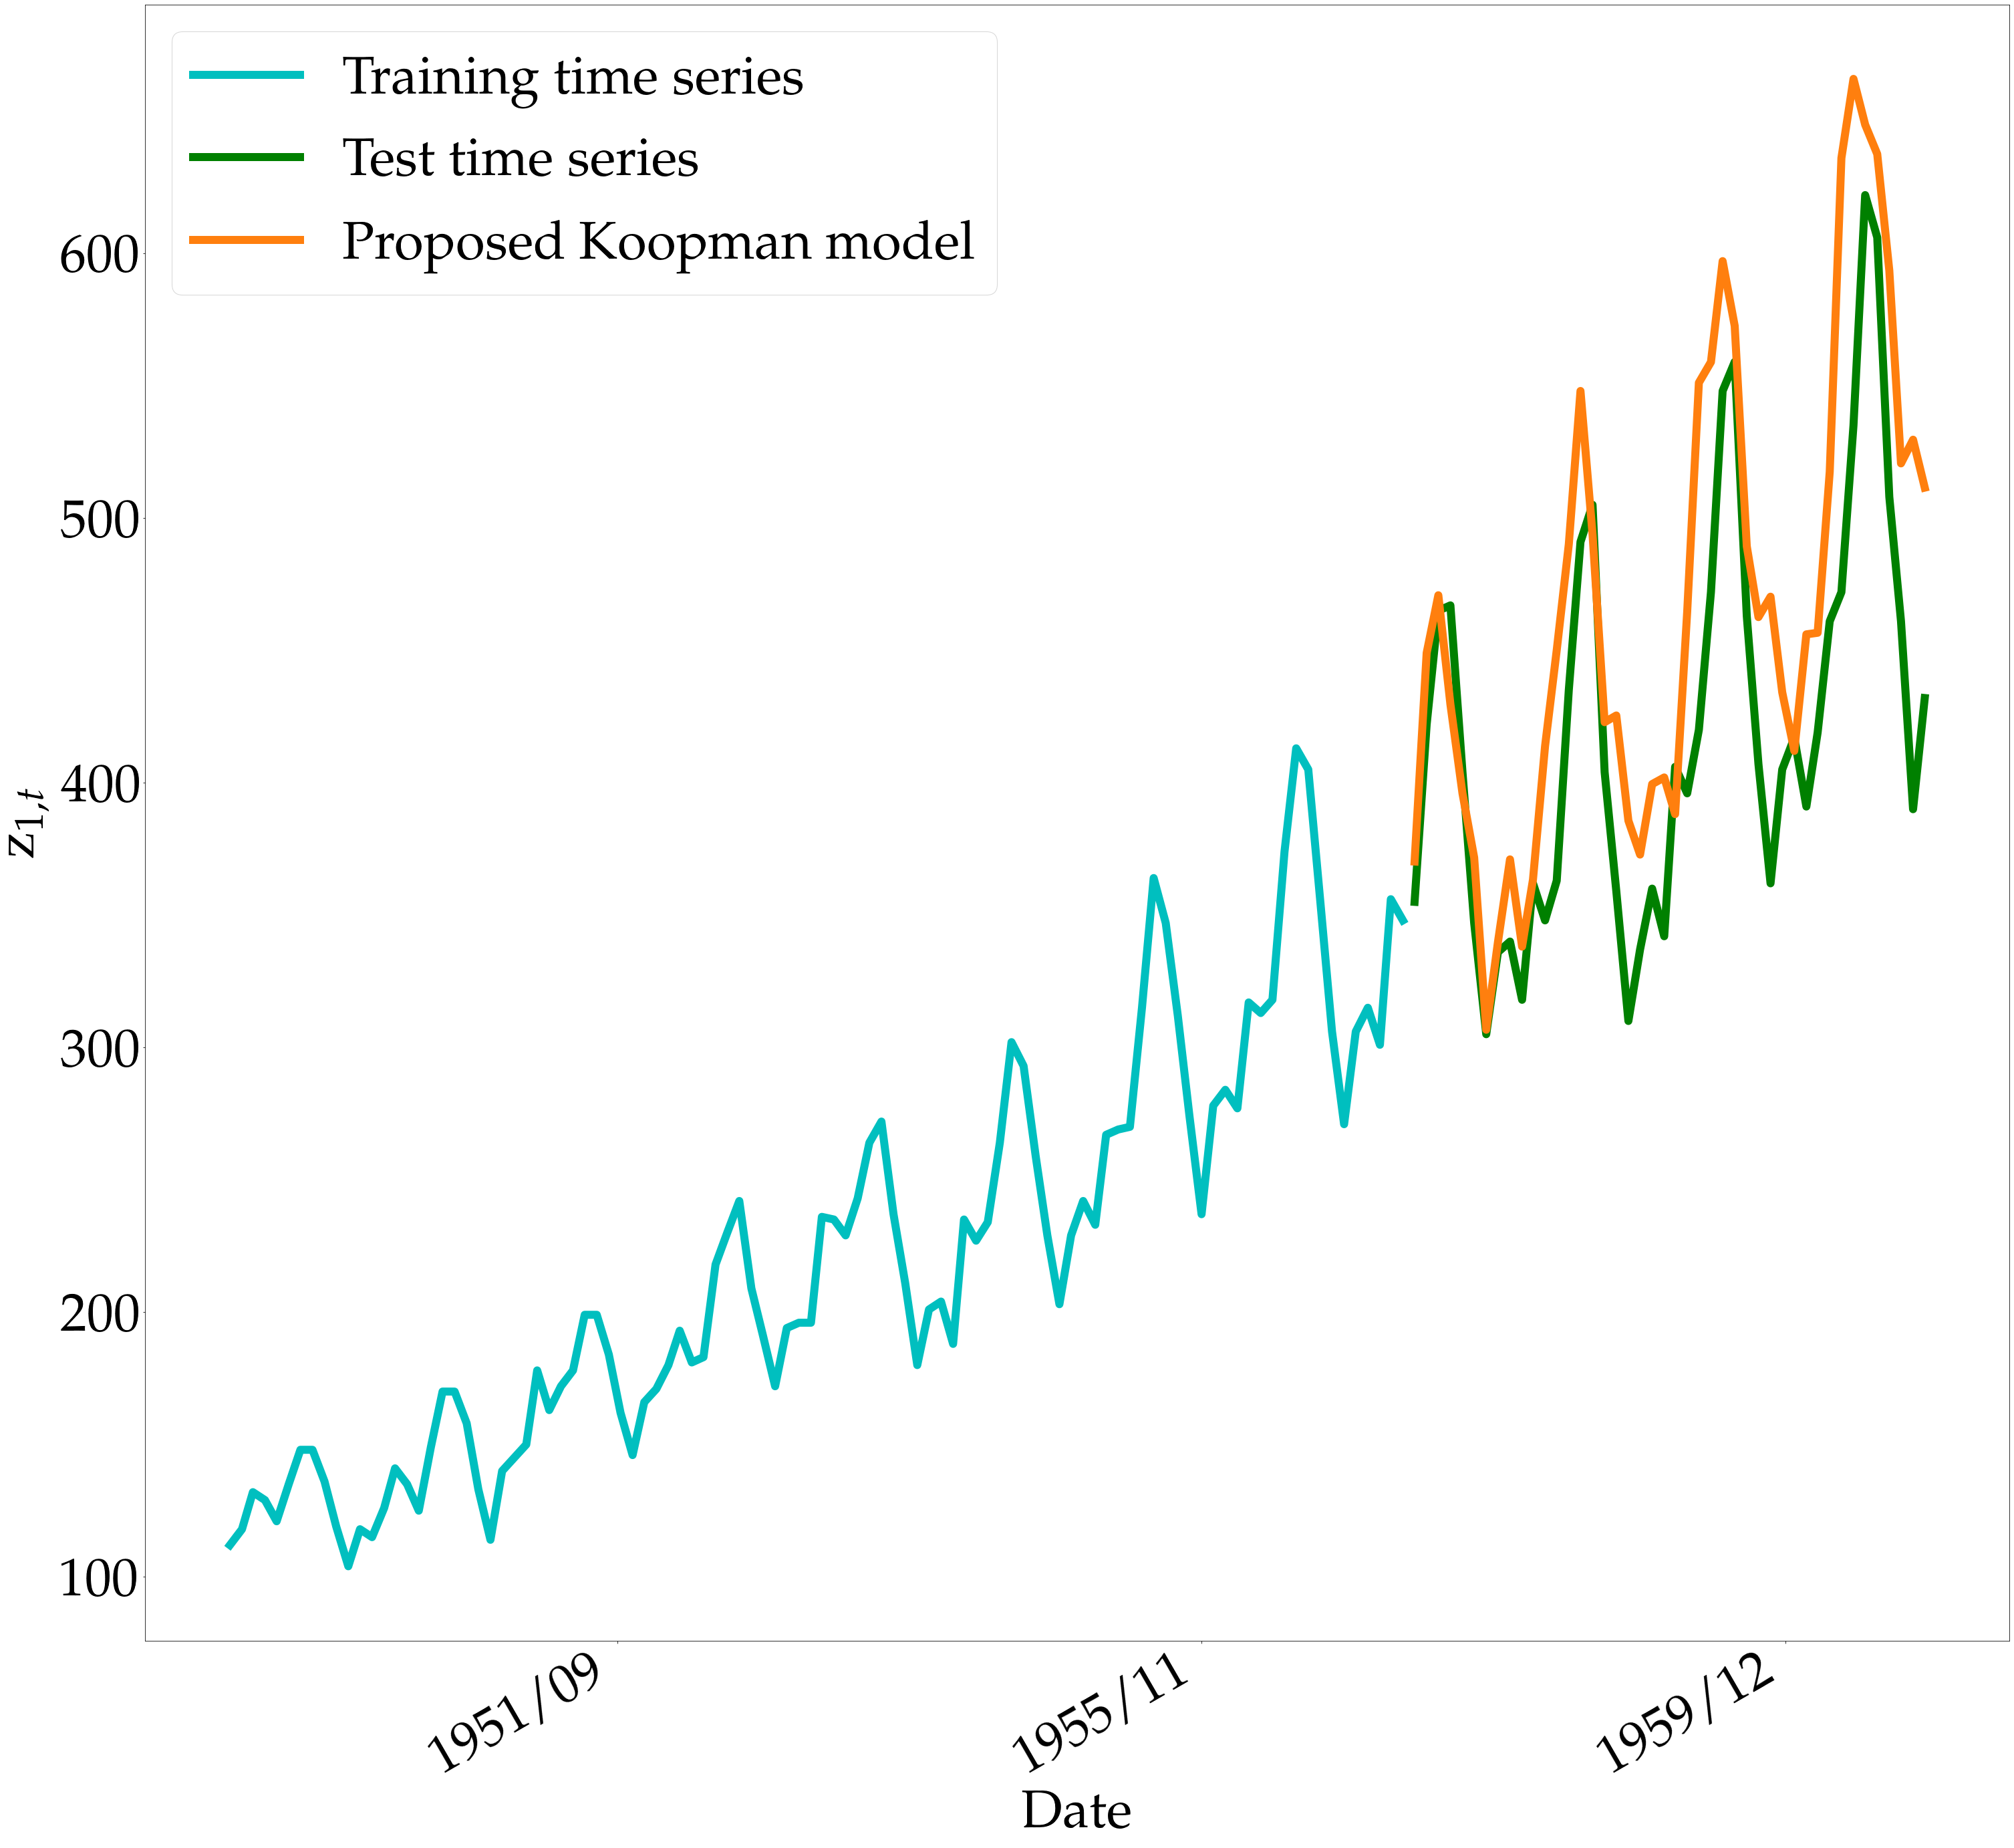

In [15]:
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 80})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
fig=plt.figure(figsize=(50,50))

train_series     = np.zeros((res['train_data'].shape[1]+res['test_data'].shape[1],1))*np.nan
test_series      = np.zeros((res['train_data'].shape[1]+res['test_data'].shape[1],1))*np.nan
predicted_series = np.zeros((res['train_data'].shape[1]+res['test_data'].shape[1],1))*np.nan
train_series[:res['train_data'].shape[1],:]     = res['train_data'][0,:,:]
test_series[res['train_data'].shape[1]:,:]      = res['test_data'][0,:,:]
predicted_series[res['train_data'].shape[1]:,:] = res['infered_test'][0,1:res['test_data'].shape[1]+1,:1]

import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1500))
plt.plot(formated_dates,train_series,lw = 12,c = 'c',label = 'Training time series')
plt.plot(formated_dates,test_series,lw = 12,c = 'g',label = 'Test time series')
plt.plot(formated_dates,predicted_series,lw = 12,c = 'tab:orange',label = 'Proposed Koopman model')
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('${\mathrm{z}}_{1,t}$')
plt.legend(markerscale=2)